In [1]:
import pandas as pd
df = pd.read_csv("data/pillbox_train_test_F.csv")

print("="*60)
print("SHAPE CLASS DISTRIBUTION")
print("="*60)
shape_counts = df['splshape_text'].value_counts().sort_values()
print(shape_counts)
print(f"Classes with only 1 sample: {(shape_counts == 1).sum()}")


print("\n" + "="*60)
print("COLOR CLASS DISTRIBUTION")
print("="*60)
color_counts = df['splcolor_text'].value_counts().sort_values()
print(color_counts)
print(f"Classes with only 1 sample: {(color_counts == 1).sum()}")

df.head()

SHAPE CLASS DISTRIBUTION
splshape_text
PENTAGON (5 SIDED)      1
TEAR                    1
FREEFORM                2
SQUARE                  6
DIAMOND                 7
TRAPEZOID               7
RECTANGLE               7
TRIANGLE               10
CAPSULE               200
OVAL                  484
ROUND                 652
Name: count, dtype: int64
Classes with only 1 sample: 2

COLOR CLASS DISTRIBUTION
splcolor_text
BLACK          1
TURQUOISE      2
PURPLE        11
GRAY          17
RED           25
GREEN         50
BROWN         61
BLUE          78
ORANGE       112
PINK         138
YELLOW       180
WHITE        702
Name: count, dtype: int64
Classes with only 1 sample: 1


,Unnamed: 0,ID,splcolor_text,splshape_text,product_code,medicine_name,dosage_form,splimage,splimprint,original_name,num_colors,num_imprints,image_path,shape_label,color_label
0,4670,4953,BLUE,ROUND,43353-944,METOPROLOL TARTRATE,C42931,433530944,C;75,433530944.jpg,1,2.0,data/pillbox_production_images_full_202008/433...,10,1
1,7547,4335,TURQUOISE,ROUND,0054-4186,DEXAMETHASONE,C42998,00054-4186-25_4A232579,54;769,00054-4186-25_4A232579.jpg,1,2.0,data/pillbox_production_images_full_202008/000...,10,9
2,80,36136,PINK,ROUND,0781-5087,CARBAMAZEPINE,C42927,007815087,T;200;mg,007815087.jpg,1,3.0,data/pillbox_production_images_full_202008/007...,10,6
3,8654,27180,WHITE,ROUND,69189-4097,BACLOFEN,C42998,00172-4097-60,4097;TV,00172-4097-60.jpg,1,2.0,data/pillbox_production_images_full_202008/001...,10,10
4,5520,26801,WHITE,ROUND,50580-496,TYLENOL,C42998,50580-0496-60_FF03FFBF,TYLENOL;325,50580-0496-60_FF03FFBF.jpg,1,2.0,data/pillbox_production_images_full_202008/505...,10,10


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, auc
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [3]:
# Filter out SEMI-CIRCLE if present and verify image paths exist
shapes_to_remove = ['PENTAGON (5 SIDED)', 'TEAR']
colors_to_remove = ['BLACK']

df_clean = df[
    (~df['splshape_text'].isin(shapes_to_remove)) & 
    (~df['splcolor_text'].isin(colors_to_remove))
].copy()

# Check if image_path column exists, if not create it
if 'image_path' not in df_clean.columns:
    df_clean['image_path'] = df_clean['original_name'].apply(
        lambda x: os.path.join('data/pillbox_production_images_full_202008', x)
    )

df_clean = df_clean[df_clean['image_path'].apply(os.path.exists)]

# Initialize label encoders
le_shape = LabelEncoder()
le_color = LabelEncoder()
df_clean['shape_label'] = le_shape.fit_transform(df_clean['splshape_text'])
df_clean['color_label'] = le_color.fit_transform(df_clean['splcolor_text'])

# Split into train and test (75/25 split)
train_df, test_df = train_test_split(
    df_clean, test_size=0.25, random_state=42, stratify=df_clean['shape_label']
)

print(f'Train: {len(train_df)}, Test: {len(test_df)}')
print(f'Shape classes: {len(le_shape.classes_)}, Color classes: {len(le_color.classes_)}')

Train: 1030, Test: 344
Shape classes: 9, Color classes: 11


In [4]:
class PillDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        shape_label = self.df.loc[idx, 'shape_label']
        color_label = self.df.loc[idx, 'color_label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, shape_label, color_label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PillDataset(train_df, train_transform)
test_dataset = PillDataset(test_df, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [5]:
class MultiTaskResNet(nn.Module):
    def __init__(self, num_shapes, num_colors):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.shape_head = nn.Linear(in_features, num_shapes)
        self.color_head = nn.Linear(in_features, num_colors)
    
    def forward(self, x):
        features = self.backbone(x)
        shape_out = self.shape_head(features)
        color_out = self.color_head(features)
        return shape_out, color_out

model = MultiTaskResNet(len(le_shape.classes_), len(le_color.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

In [6]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    shape_correct = 0
    color_correct = 0
    total = 0
    
    for images, shape_labels, color_labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        shape_labels = shape_labels.to(device)
        color_labels = color_labels.to(device)
        
        optimizer.zero_grad()
        shape_out, color_out = model(images)
        
        shape_loss = criterion(shape_out, shape_labels)
        color_loss = criterion(color_out, color_labels)
        loss = shape_loss + color_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, shape_pred = shape_out.max(1)
        _, color_pred = color_out.max(1)
        total += shape_labels.size(0)
        shape_correct += shape_pred.eq(shape_labels).sum().item()
        color_correct += color_pred.eq(color_labels).sum().item()
    
    return running_loss / total, shape_correct / total, color_correct / total

In [7]:
def evaluate(model, loader):
    model.eval()
    shape_probs = []
    color_probs = []
    shape_labels = []
    color_labels = []
    shape_preds = []
    color_preds = []
    
    with torch.no_grad():
        for images, s_labels, c_labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            shape_out, color_out = model(images)
            
            s_probs = torch.softmax(shape_out, dim=1)
            c_probs = torch.softmax(color_out, dim=1)
            
            shape_probs.append(s_probs.cpu().numpy())
            color_probs.append(c_probs.cpu().numpy())
            shape_labels.append(s_labels.numpy())
            color_labels.append(c_labels.numpy())
            shape_preds.append(shape_out.cpu().numpy())
            color_preds.append(color_out.cpu().numpy())
    
    return {
        'shape_probs': np.vstack(shape_probs),
        'color_probs': np.vstack(color_probs),
        'shape_labels': np.concatenate(shape_labels),
        'color_labels': np.concatenate(color_labels),
        'shape_preds': np.vstack(shape_preds),
        'color_preds': np.vstack(color_preds)
    }

In [8]:
def compute_metrics(probs, labels, preds, task_name):
    pred_classes = np.argmax(preds, axis=1)
    
    top1_acc = (pred_classes == labels).mean()
    
    top3_indices = np.argsort(preds, axis=1)[:, -3:]
    top3_acc = np.mean([labels[i] in top3_indices[i] for i in range(len(labels))])
    
    n_classes = probs.shape[1]
    pr_aucs = []
    ious = []
    aps = []
    
    for i in range(n_classes):
        binary_labels = (labels == i).astype(int)
        class_probs = probs[:, i]
        
        if binary_labels.sum() == 0:
            continue
        
        precision, recall, _ = precision_recall_curve(binary_labels, class_probs)
        pr_aucs.append(auc(recall, precision))
        
        pred_class = (pred_classes == i).astype(int)
        intersection = (binary_labels * pred_class).sum()
        union = (binary_labels + pred_class).clip(0, 1).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
        
        sorted_idx = np.argsort(class_probs)[::-1]
        tp = binary_labels[sorted_idx].cumsum()
        fp = (1 - binary_labels[sorted_idx]).cumsum()
        p = tp / (tp + fp + 1e-10)
        r = tp / binary_labels.sum()
        ap = np.sum((r[1:] - r[:-1]) * p[1:])
        aps.append(ap)
    
    return {
        f'{task_name}_top1_acc': top1_acc,
        f'{task_name}_top3_acc': top3_acc,
        f'{task_name}_iou': np.mean(ious),
        f'{task_name}_map': np.mean(aps),
        f'{task_name}_pr_auc': np.mean(pr_aucs)
    }

In [9]:
epochs = 10
best_shape_acc = 0

for epoch in range(epochs):
    train_loss, train_shape_acc, train_color_acc = train_epoch(model, train_loader, criterion, optimizer)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Shape Acc: {train_shape_acc:.4f}, Color Acc: {train_color_acc:.4f}')
    
    results = evaluate(model, test_loader)
    
    shape_metrics = compute_metrics(results['shape_probs'], results['shape_labels'], results['shape_preds'], 'shape')
    color_metrics = compute_metrics(results['color_probs'], results['color_labels'], results['color_preds'], 'color')
    
    print(f"SHAPE - Top-1: {shape_metrics['shape_top1_acc']:.4f}, Top-3: {shape_metrics['shape_top3_acc']:.4f}, "
          f"IoU: {shape_metrics['shape_iou']:.4f}, mAP: {shape_metrics['shape_map']:.4f}, PR-AUC: {shape_metrics['shape_pr_auc']:.4f}")
    print(f"COLOR - Top-1: {color_metrics['color_top1_acc']:.4f}, Top-3: {color_metrics['color_top3_acc']:.4f}, "
          f"IoU: {color_metrics['color_iou']:.4f}, mAP: {color_metrics['color_map']:.4f}, PR-AUC: {color_metrics['color_pr_auc']:.4f}\n")
    
    scheduler.step(shape_metrics['shape_top1_acc'])
    
    if shape_metrics['shape_top1_acc'] > best_shape_acc:
        best_shape_acc = shape_metrics['shape_top1_acc']
        torch.save(model.state_dict(), 'best_resnet_multitask.pth')

Training: 100%|██████████| 33/33 [00:30<00:00,  1.08it/s]


Epoch 1/10 - Loss: 1.4947, Shape Acc: 0.8515, Color Acc: 0.7272


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


SHAPE - Top-1: 0.8779, Top-3: 0.9738, IoU: 0.2681, mAP: 0.3685, PR-AUC: 0.4223
COLOR - Top-1: 0.2849, Top-3: 0.7413, IoU: 0.0992, mAP: 0.3911, PR-AUC: 0.3921



Training: 100%|██████████| 33/33 [00:23<00:00,  1.38it/s]


Epoch 2/10 - Loss: 0.9294, Shape Acc: 0.8835, Color Acc: 0.8146


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


SHAPE - Top-1: 0.8866, Top-3: 0.9942, IoU: 0.4664, mAP: 0.4002, PR-AUC: 0.6521
COLOR - Top-1: 0.7587, Top-3: 0.9506, IoU: 0.4106, mAP: 0.5430, PR-AUC: 0.6034



Training: 100%|██████████| 33/33 [00:21<00:00,  1.54it/s]


Epoch 3/10 - Loss: 0.9118, Shape Acc: 0.9000, Color Acc: 0.8223


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


SHAPE - Top-1: 0.9012, Top-3: 0.9855, IoU: 0.3944, mAP: 0.4808, PR-AUC: 0.6808
COLOR - Top-1: 0.7849, Top-3: 0.9651, IoU: 0.3728, mAP: 0.5936, PR-AUC: 0.6593



Training: 100%|██████████| 33/33 [00:21<00:00,  1.55it/s]


Epoch 4/10 - Loss: 0.7838, Shape Acc: 0.9282, Color Acc: 0.8340


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


SHAPE - Top-1: 0.9099, Top-3: 0.9913, IoU: 0.5437, mAP: 0.4978, PR-AUC: 0.7781
COLOR - Top-1: 0.8227, Top-3: 0.9651, IoU: 0.4645, mAP: 0.6493, PR-AUC: 0.7679



Training: 100%|██████████| 33/33 [00:21<00:00,  1.53it/s]


Epoch 5/10 - Loss: 0.7055, Shape Acc: 0.9146, Color Acc: 0.8583


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


SHAPE - Top-1: 0.8983, Top-3: 0.9913, IoU: 0.5488, mAP: 0.5547, PR-AUC: 0.7510
COLOR - Top-1: 0.8081, Top-3: 0.9535, IoU: 0.4751, mAP: 0.6078, PR-AUC: 0.6030



Training: 100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


Epoch 6/10 - Loss: 0.5936, Shape Acc: 0.9233, Color Acc: 0.8699


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


SHAPE - Top-1: 0.9244, Top-3: 0.9913, IoU: 0.6171, mAP: 0.4680, PR-AUC: 0.8140
COLOR - Top-1: 0.8605, Top-3: 0.9622, IoU: 0.5096, mAP: 0.6156, PR-AUC: 0.6391



Training: 100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


Epoch 7/10 - Loss: 0.5375, Shape Acc: 0.9427, Color Acc: 0.8913


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


SHAPE - Top-1: 0.8924, Top-3: 0.9942, IoU: 0.5289, mAP: 0.4411, PR-AUC: 0.7934
COLOR - Top-1: 0.8808, Top-3: 0.9477, IoU: 0.5922, mAP: 0.6256, PR-AUC: 0.6996



Training: 100%|██████████| 33/33 [00:21<00:00,  1.54it/s]


Epoch 8/10 - Loss: 0.5894, Shape Acc: 0.9340, Color Acc: 0.8748


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


SHAPE - Top-1: 0.9041, Top-3: 0.9942, IoU: 0.6621, mAP: 0.5184, PR-AUC: 0.8712
COLOR - Top-1: 0.8576, Top-3: 0.9680, IoU: 0.5672, mAP: 0.6347, PR-AUC: 0.7646



Training: 100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 9/10 - Loss: 0.5836, Shape Acc: 0.9272, Color Acc: 0.8816


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


SHAPE - Top-1: 0.8895, Top-3: 0.9826, IoU: 0.5226, mAP: 0.4604, PR-AUC: 0.6020
COLOR - Top-1: 0.8721, Top-3: 0.9680, IoU: 0.5744, mAP: 0.6310, PR-AUC: 0.7476



Training: 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 10/10 - Loss: 0.4659, Shape Acc: 0.9466, Color Acc: 0.9019


Evaluating: 100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


SHAPE - Top-1: 0.9302, Top-3: 0.9884, IoU: 0.6825, mAP: 0.4557, PR-AUC: 0.7424
COLOR - Top-1: 0.8953, Top-3: 0.9738, IoU: 0.6835, mAP: 0.6775, PR-AUC: 0.8212



In [10]:
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)
print("\nSHAPE METRICS:")
for key, val in shape_metrics.items():
    print(f"  {key}: {val:.4f}")
print("\nCOLOR METRICS:")
for key, val in color_metrics.items():
    print(f"  {key}: {val:.4f}")


FINAL TEST SET EVALUATION

SHAPE METRICS:
  shape_top1_acc: 0.9302
  shape_top3_acc: 0.9884
  shape_iou: 0.6825
  shape_map: 0.4557
  shape_pr_auc: 0.7424

COLOR METRICS:
  color_top1_acc: 0.8953
  color_top3_acc: 0.9738
  color_iou: 0.6835
  color_map: 0.6775
  color_pr_auc: 0.8212


# Save Model

In [11]:
import pickle
import os

os.makedirs('resnet_model', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'shape_encoder': le_shape,
    'color_encoder': le_color,
    'num_shape_classes': len(le_shape.classes_),
    'num_color_classes': len(le_color.classes_)
}, 'resnet_model/pill_classifier_full.pth')

with open('resnet_model/label_encoders.pkl', 'wb') as f:
    pickle.dump({'shape': le_shape, 'color': le_color}, f)

print("Model saved to 'resnet_model/pill_classifier_full.pth'")
print("Label encoders saved to 'resnet_model/label_encoders.pkl'")

Model saved to 'resnet_model/pill_classifier_full.pth'
Label encoders saved to 'resnet_model/label_encoders.pkl'


## Load Model for Inference

To load the model later for predictions:

In [12]:
checkpoint = torch.load('resnet_model/pill_classifier_full.pth', weights_only=False)

loaded_model = MultiTaskResNet(
    checkpoint['num_shape_classes'],
    checkpoint['num_color_classes']
).to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

shape_encoder = checkpoint['shape_encoder']
color_encoder = checkpoint['color_encoder']

print("Model loaded successfully")
print(f"Shape classes: {list(shape_encoder.classes_)}")
print(f"Color classes: {list(color_encoder.classes_)}")

Model loaded successfully
Shape classes: ['CAPSULE', 'DIAMOND', 'FREEFORM', 'OVAL', 'RECTANGLE', 'ROUND', 'SQUARE', 'TRAPEZOID', 'TRIANGLE']
Color classes: ['BLUE', 'BROWN', 'GRAY', 'GREEN', 'ORANGE', 'PINK', 'PURPLE', 'RED', 'TURQUOISE', 'WHITE', 'YELLOW']


# Visualisations

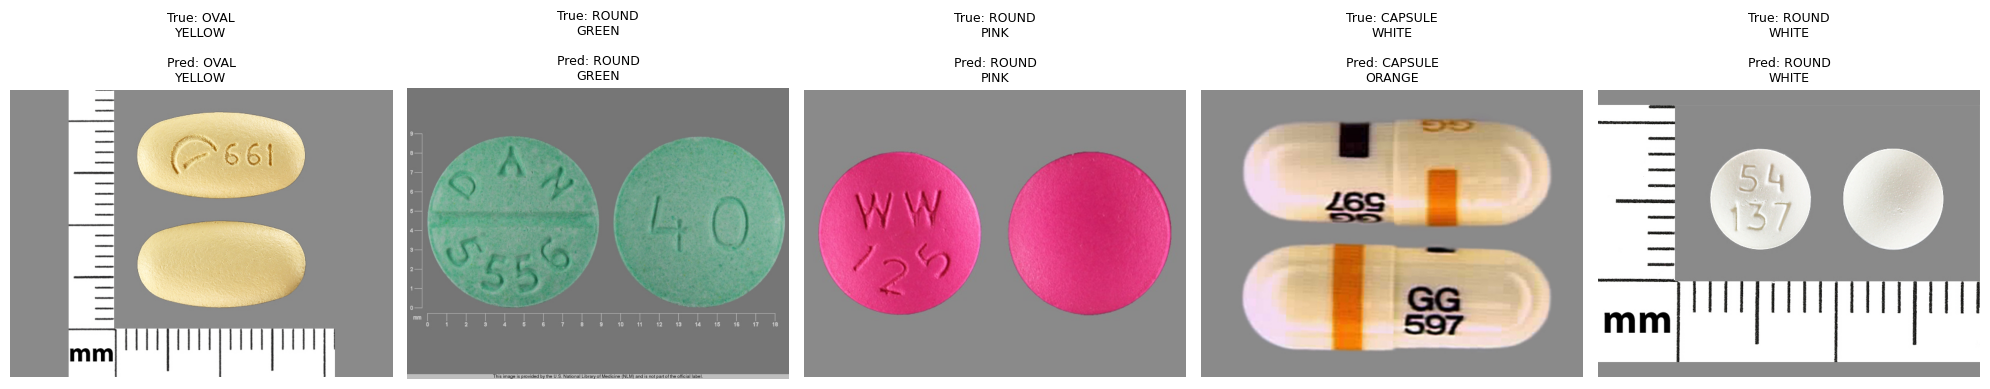

In [13]:
import matplotlib.pyplot as plt
import random

random.seed(42)
sample_indices = random.sample(range(len(test_df)), 5)
sample_data = test_df.iloc[sample_indices].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    img_path = sample_data.loc[idx, 'image_path']
    true_shape = sample_data.loc[idx, 'splshape_text']
    true_color = sample_data.loc[idx, 'splcolor_text']
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        shape_out, color_out = loaded_model(img_tensor)
        pred_shape_idx = shape_out.argmax(dim=1).item()
        pred_color_idx = color_out.argmax(dim=1).item()
    
    pred_shape = shape_encoder.inverse_transform([pred_shape_idx])[0]
    pred_color = color_encoder.inverse_transform([pred_color_idx])[0]
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f"True: {true_shape}\n{true_color}\n\n"
        f"Pred: {pred_shape}\n{pred_color}",
        fontsize=9
    )

plt.tight_layout()
plt.show()

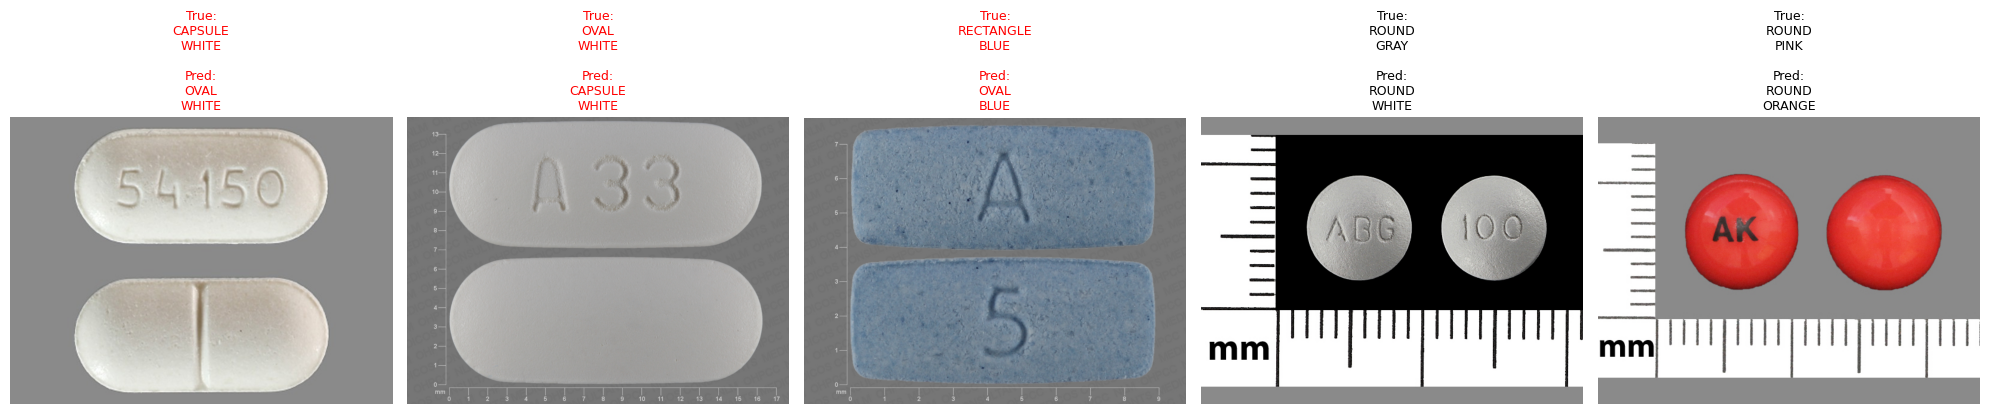

5 misclassified examples


In [14]:
misclassified = []

for idx in range(len(test_df)):
    row = test_df.iloc[idx]
    img_path = row['image_path']
    true_shape = row['splshape_text']
    true_color = row['splcolor_text']
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        shape_out, color_out = loaded_model(img_tensor)
        pred_shape_idx = shape_out.argmax(dim=1).item()
        pred_color_idx = color_out.argmax(dim=1).item()
    
    pred_shape = shape_encoder.inverse_transform([pred_shape_idx])[0]
    pred_color = color_encoder.inverse_transform([pred_color_idx])[0]
    
    if pred_shape != true_shape or pred_color != true_color:
        misclassified.append({
            'img': img,
            'true_shape': true_shape,
            'true_color': true_color,
            'pred_shape': pred_shape,
            'pred_color': pred_color
        })
        if len(misclassified) == 5:
            break

if misclassified:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, example in enumerate(misclassified):
        axes[i].imshow(example['img'])
        axes[i].axis('off')
        axes[i].set_title(
            f"True:\n{example['true_shape']}\n{example['true_color']}\n\n"
            f"Pred:\n{example['pred_shape']}\n{example['pred_color']}",
            fontsize=9,
            color='red' if example['pred_shape'] != example['true_shape'] else 'black'
        )
    plt.tight_layout()
    plt.show()
    print(f"{len(misclassified)} misclassified examples")
else:
    print("No misclassifications found!")